In [1]:
import numpy as np
import nilearn
import nibabel as nib
from nilearn import datasets, plotting, regions
import matplotlib.pyplot as plt
import matplotlib as mpl
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
import brainspace
import seaborn as sns
import hcp_utils as hcp
import pandas as pd
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from modeling_utils import *
import os
surf_lh, surf_rh = load_conte69()
from nilearn.connectome import sym_matrix_to_vec
import pickle
import json
import seaborn as sns


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer', 1000)
schaefer_labels_1000 = load_parcellation('schaefer', scale=1000, join=True)

schaefer_region_names = nilearn.datasets.fetch_atlas_schaefer_2018(1000, yeo_networks = 7)
#schaefer_coords = plotting.find_parcellation_cut_coords(schaefer_region_names["maps"])

In [3]:
mpl.rcParams['svg.fonttype'] = 'none'

## Descriptive Stats

In [3]:
#data_paths = json.load(open('data_paths.json', 'r'))

data_paths = {
"COBRE-SCZ": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/COBRE/clean_data/SCZ",
"COBRE-controls": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/COBRE/clean_data/controls",
"LA5c": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data",
"SRPBS-1600-KTT": "/Users/VictoriaShevchenko/Documents/PhD/SCZ/SRPBS_1600/KTT/clean_data",
}

In [3]:
diagnosis_mapping = {
    'CONTROL': 0,
    'SCHZ': 1,
    'Schizophrenia_Strict': 1,
    'No_Known_Disorder': 0,
    4: 1,
    0: 0
}

In [41]:
participants["path"][0]

'/gpfs3/well/margulies/projects/data/COBRE/SCZ/derivatives/fmriprep/clean_data'

In [ ]:
# load json with data_paths
data_paths = json.load(open('data_paths.json', 'r'))

In [ ]:
sys.path.append("../../PyConn")
from NeuroConn.preprocessing.preprocessing import FmriPreppedDataSet

participants = pd.read_csv('participants.csv')
participants["mean_fd"] = np.nan

for data_path in data_paths:
    dataset = FmriPreppedDataSet(data_path)
    for subject in dataset.subjects:
        if subject in participants["participant_id"].values:
            sub_dir = os.path.join(data_path, "derivatives/fmriprep", f"sub-{subject}")
            # search for files ending with "confounds_timeseries.tsv" in all subdirectories
            confounds = []
            for root, dirs, files in os.walk(sub_dir):
                for file in files:
                    if file.endswith("confounds_timeseries.tsv"):
                        confounds.append(os.path.join(root, file))
            # load confounds
            confounds = [pd.read_csv(confound, sep = "\t") for confound in confounds]
            if len(confounds) > 1:
                confounds = pd.concat(confounds, axis = 0)
            else:
                confounds = confounds[0]
            mean_fd = confounds['framewise_displacement'].mean()
            participants.loc[participants["participant_id"] == subject, "mean_fd"] = mean_fd

participants.to_csv('participants.csv', index = False)

In [46]:
grouped =participants.groupby(['dataset'])
grouped.age.describe()

count       mean        std   min   25%   50%    75%   max
dataset                                                                   
COBRE           140.0  37.285714  12.460750  18.0  26.0  35.5  48.25  65.0
LA5c            147.0  32.340136   8.845320  21.0  25.0  30.0  40.00  50.0
SRPBS-1600-KTT  121.0  32.214876  10.204743  19.0  24.0  31.0  39.00  57.0
SRPBS-1600-KUT  202.0  37.707921  13.158764  18.0  24.0  38.0  47.00  78.0
SRPBS-1600-SWA  120.0  30.733333   9.529903  19.0  23.0  27.0  35.25  55.0
SRPBS-1600-UTO  206.0  34.859223  16.529193  16.0  21.0  31.0  44.00  80.0

In [47]:
grouped.mean_fd.describe()

count      mean       std       min       25%       50%  \
dataset                                                                   
COBRE           140.0  0.268914  0.107750  0.077181  0.180296  0.250667   
LA5c            147.0  0.167184  0.085941  0.055963  0.107020  0.148093   
SRPBS-1600-KTT  121.0  0.113433  0.046971  0.046267  0.083525  0.100989   
SRPBS-1600-KUT  202.0  0.147667  0.066520  0.052553  0.099050  0.132522   
SRPBS-1600-SWA  120.0  0.162711  0.078013  0.068363  0.108816  0.139429   
SRPBS-1600-UTO  206.0  0.125349  0.068748  0.050427  0.079736  0.106171   

                     75%       max  
dataset                             
COBRE           0.343920  0.498206  
LA5c            0.205782  0.444074  
SRPBS-1600-KTT  0.134685  0.291186  
SRPBS-1600-KUT  0.179969  0.413938  
SRPBS-1600-SWA  0.186154  0.465692  
SRPBS-1600-UTO  0.149676  0.495019

In [49]:
grouped.sex.value_counts()

dataset         sex
COBRE           0      107
                1       33
LA5c            0       88
                1       59
SRPBS-1600-KTT  0       74
                1       47
SRPBS-1600-KUT  0      113
                1       89
SRPBS-1600-SWA  0      101
                1       19
SRPBS-1600-UTO  1      104
                0      102
Name: count, dtype: int64

In [50]:
grouped.diagnosis.value_counts()

dataset         diagnosis
COBRE           0             81
                1             59
LA5c            0            102
                1             45
SRPBS-1600-KTT  0             75
                1             46
SRPBS-1600-KUT  0            159
                1             43
SRPBS-1600-SWA  0            101
                1             19
SRPBS-1600-UTO  0            170
                1             36
Name: count, dtype: int64

## Gradient

### Atlas

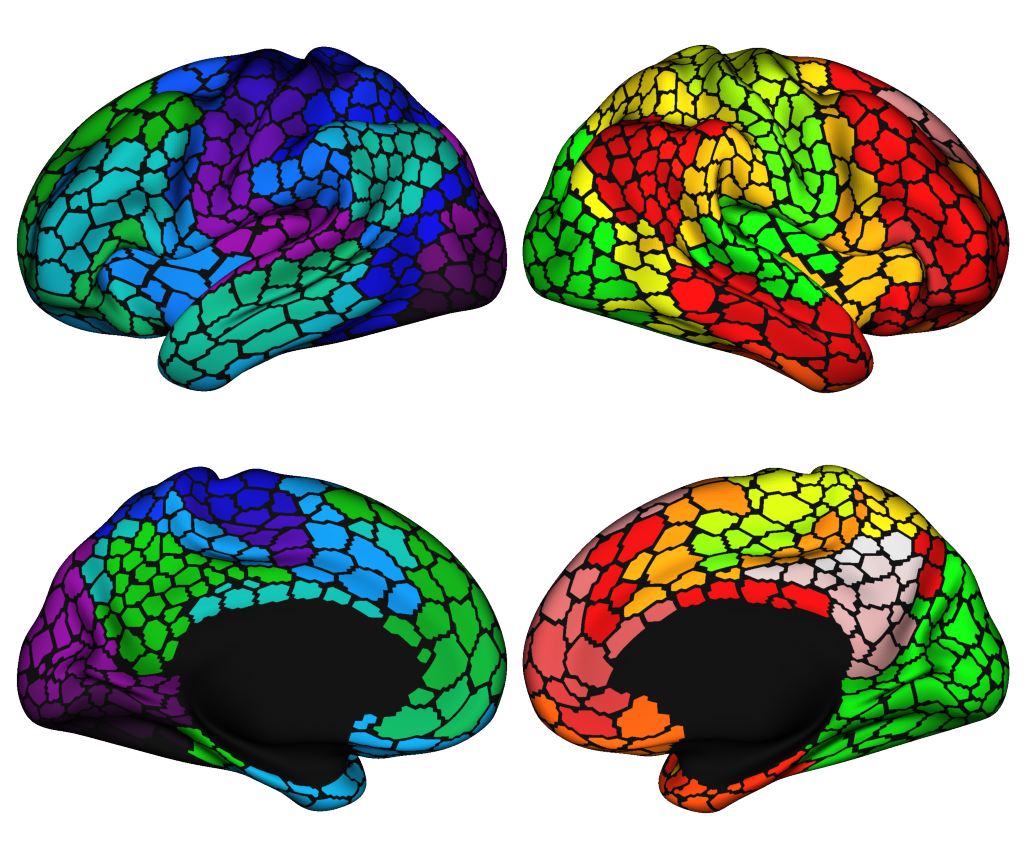

In [177]:

schaefer_plot = Plot(lh, rh, size=(1200, 1000))
schaefer_plot.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=False, cmap="nipy_spectral")
schaefer_plot.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)
fig = schaefer_plot.build()
fig.savefig(f"../../figures/cortex_regions/schaefer1000_atlas.svg", format = "svg", dpi = 300, bbox_inches='tight')

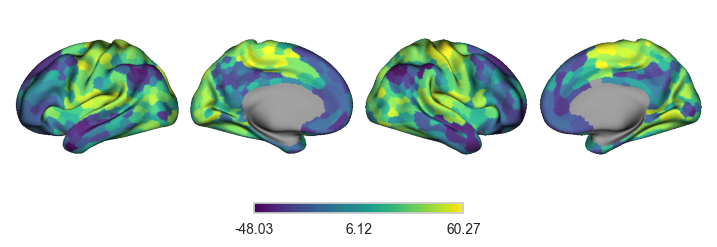

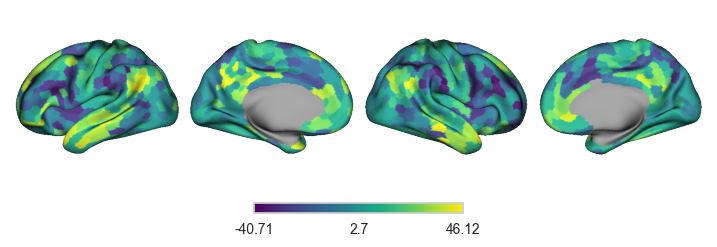

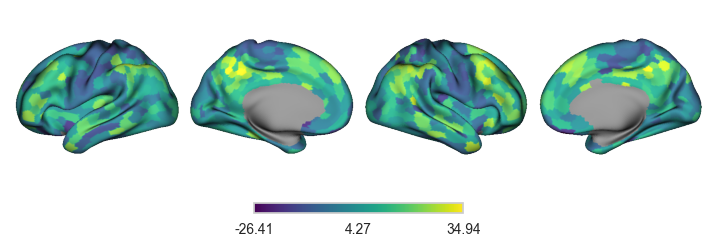

In [50]:
hcp_grad1_plot = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')
hcp_grad1_plot.add_layer({'left': grad_mapped[0][:32492], 'right': grad_mapped[0][32492:]}, cmap = "viridis", zero_transparent=True)
fig = hcp_grad1_plot.build()

hcp_grad2_plot = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')
hcp_grad2_plot.add_layer({'left': grad_mapped[1][:32492], 'right': grad_mapped[1][32492:]}, cmap = "viridis", zero_transparent=True)
fig = hcp_grad2_plot.build()

hcp_grad3_plot = Plot(lh, rh, size=(800, 200), zoom=1.2, layout='row')
hcp_grad3_plot.add_layer({'left': grad_mapped[2][:32492], 'right': grad_mapped[2][32492:]}, cmap = "viridis", zero_transparent=True)
fig = hcp_grad3_plot.build()


In [509]:
matrix = np.load("/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data/sub-10189/func/z-conn-matrix-sub-10189-rest-schaefer1000.npy")[0]
#corr_plot = plotting.plot_matrix(matrix, figure=(10, 10), vmax=1, vmin=-1, cmap = 'plasma')


In [534]:
from brainspace.gradient.embedding import PCAMaps

pca = PCAMaps(n_components=200)
pca.fit(matrix)
grads_var_explained = pca.lambdas_ / pca.lambdas_.sum()
grads = np.arange(1, 201)
grads_var_explained = np.stack([grads_var_explained, grads])

In [535]:
grads_var_explained = pd.DataFrame(grads_var_explained.T, columns = ["Variance Explained", "Gradients"])

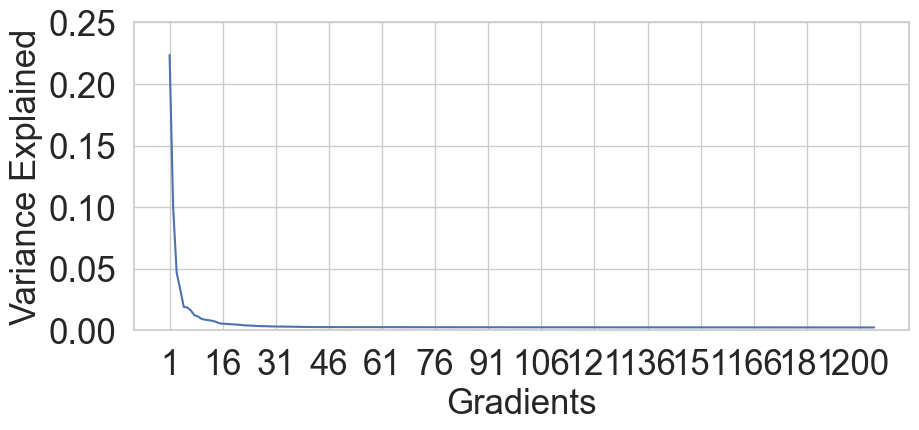

In [537]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=grads_var_explained, x="Gradients", y="Variance Explained")
ax.set_xticks(np.arange(1, 201, 15))
ax.set_xticklabels(np.append(np.arange(1, 201, 15)[:-1], 200))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=25)

ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)

# set the y-axis limits to start at 0 and end at the maximum value of "Variance Explained"
max_var_explained = grads_var_explained["Variance Explained"].max()
ax.set_ylim([-0.0001, 0.25])

plt.savefig("../../figures/grad_var_explained.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [200]:
gradients = np.load("/Users/VictoriaShevchenko/Documents/PhD/SCZ/COBRE/clean_data/controls/sub-A00004087/func/aligned-10gradients-sub-A00004087-rest-schaefer1000.npy")[0]


In [201]:
gradients = gradients[:,:3]

In [202]:
grads3_df = pd.DataFrame(gradients, columns = ["Gradient 1", "Gradient 2", "Gradient 3"])

In [409]:
import plotly.express as px

fig1 = px.scatter(grads3_df, x="Gradient 2", y="Gradient 1",
              color_continuous_scale='Viridis', color='Gradient 1', opacity=1, template='plotly_white', width=600, height=600)
# Create a copy of the initial scatter plot and modify it to only show significant dots with a different color

fig1.update_traces(marker_size=5)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         backgroundcolor="white",
                         gridcolor="black",
                         showbackground=False,
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False,
                         titlefont=dict(size=50)),
                    yaxis=dict(
                        backgroundcolor="white",
                        gridcolor="black",
                        showbackground=False,
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False,
                        titlefont=dict(size=50))))
fig1.update_layout(coloraxis_showscale=False,font=dict(
        size=18))
fig1.write_image("../../figures/grad_embedding.svg")


In [44]:
grads = [None] * 3

for i, g in enumerate(gradients.T[:3]):
    grads[i] = map_to_labels(g, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

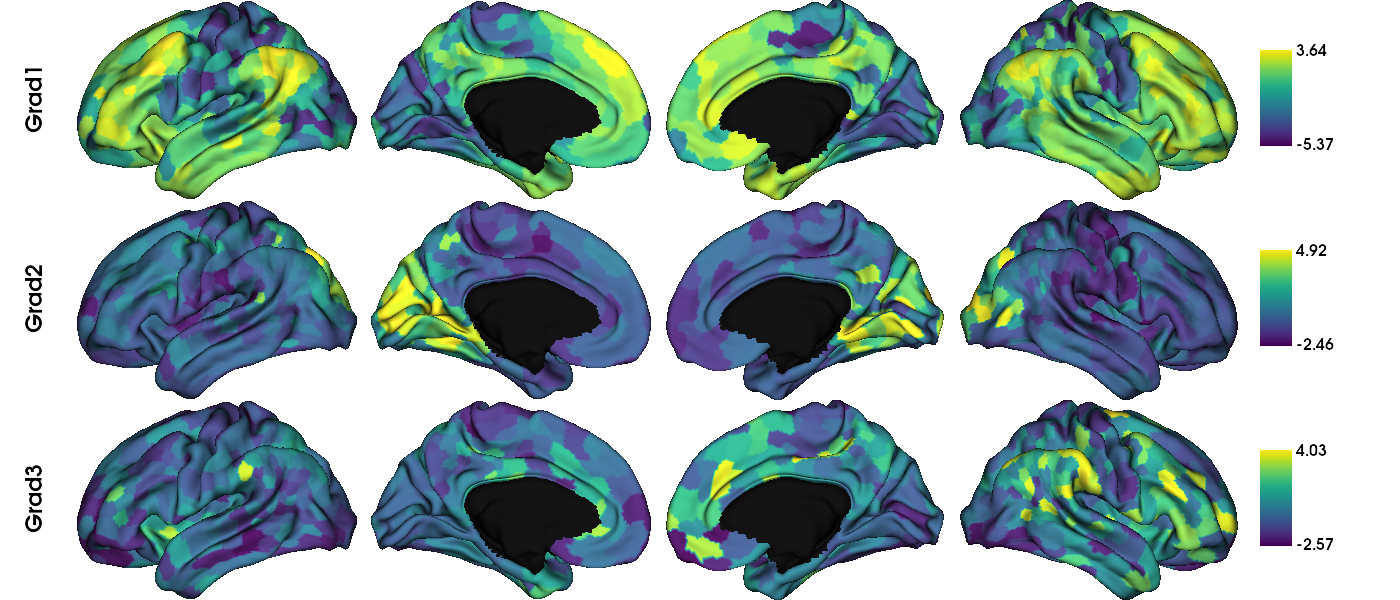

In [51]:
plot_hemispheres(surf_lh, surf_rh, array_name=grads, size=(1400, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.8, embed_nb = True)

In [56]:
dispersion = [np.load(f"/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data/sub-10189/func/{i}") for i in os.listdir("/Users/VictoriaShevchenko/Documents/PhD/SCZ/LA5c/clean_data/sub-10189/func/") if "disp" in i]

In [57]:
dispersion = np.array(dispersion)
dispersion.shape

(3, 1000)

In [58]:
disp = [None] * 3
for i, d in enumerate(dispersion):
    disp[i] = map_to_labels(d, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

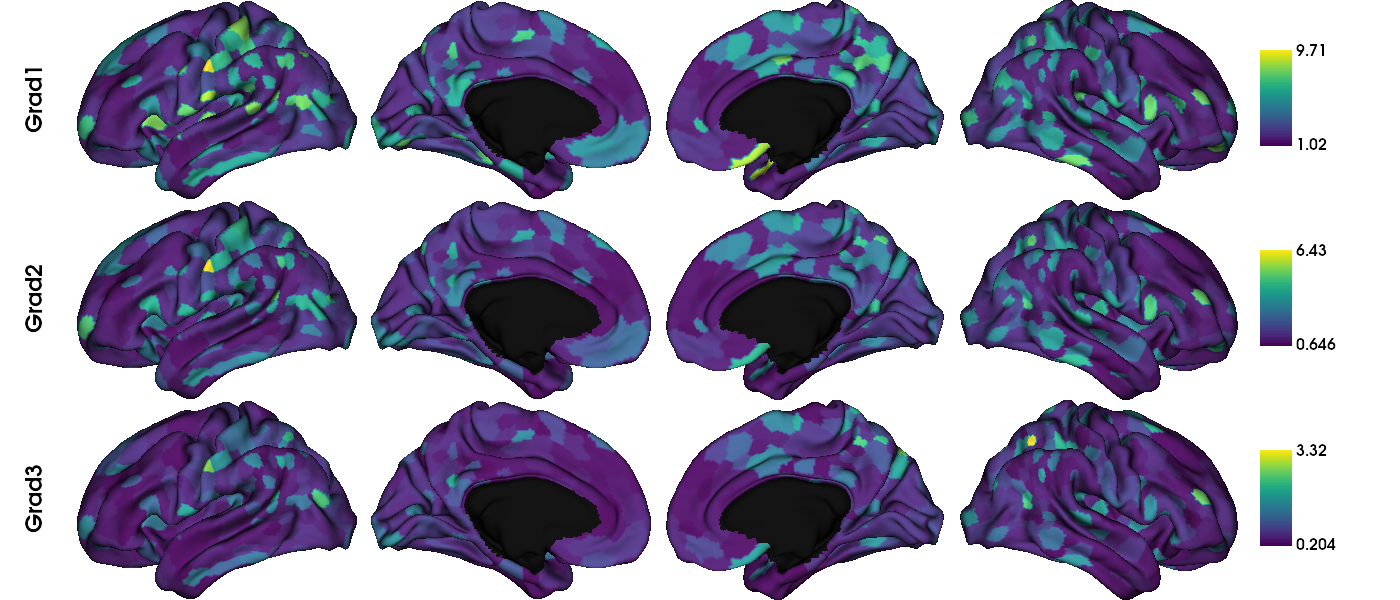

In [59]:
plot_hemispheres(surf_lh, surf_rh, array_name=disp, size=(1400, 600), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3'], zoom=1.8, embed_nb = True)

# Results

## Feature Importance

In [116]:
latent_importance = np.load("results/importances_pca.npy")#[:76]
# latent_importance_labels = ["Connectivty"] * 1 + ["Gradients"] * 31 + ["Centroid Dispersion"] * 28 + ["Cortex Dispersion"] * 16

In [118]:
importance_conn = latent_importance[:7].flatten()
importance_grad = latent_importance[7:79].flatten()
importance_centroid = latent_importance[79:107].flatten()
importance_cortex = latent_importance[107:149].flatten()

importance_conn = pd.DataFrame(importance_conn, columns = ["Importance"])
importance_conn["Feature Type"] = "Connectivity"

importance_grad = pd.DataFrame(importance_grad, columns = ["Importance"])
importance_grad["Feature Type"] = "Gradients"

importance_centroid = pd.DataFrame(importance_centroid, columns = ["Importance"])
importance_centroid["Feature Type"] = "Centroid Dispersion"

importance_cortex = pd.DataFrame(importance_cortex, columns = ["Importance"])
importance_cortex["Feature Type"] = "Cortex Dispersion"

importance = pd.concat([importance_conn, importance_grad, importance_centroid, importance_cortex])

<AxesSubplot: xlabel='Feature Type', ylabel='Importance'>

Text(0.5, 1.0, 'Component permutation importance')

(-0.023, 0.03)

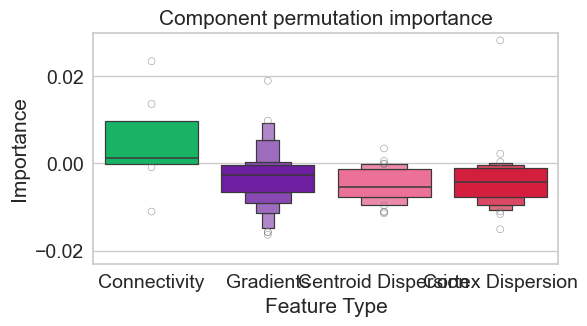

In [274]:
sns.set_style("whitegrid")
fig_dims = (6, 3)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxenplot(data=importance, x= "Feature Type", y="Importance", hue="Feature Type", palette = ["#00cc66", "#7209b7", "#ff5d8f", "#f2002b"], k_depth = "trustworthy")

ax.tick_params(axis='x', labelsize= 14)
ax.tick_params(axis='y', labelsize= 14)
#plt.title(label = "99% Threshold for Each Feature Type", fontsize = 20)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.8,1))
plt.title('Component permutation importance', fontsize = 15)
# limit y axis
plt.ylim(-0.023, 0.03)
plt.savefig("../../figures/component_importance.svg", format = "svg", dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [84]:
feature_importance_grads["Percentile"] = np.floor(feature_importance_grads["Percentile"].values).astype(int)
feature_importance_conn["Percentile"] = np.floor(feature_importance_conn["Percentile"].values).astype(int)
feature_importance_disp["Percentile"] = np.floor(feature_importance_disp["Percentile"].values).astype(int)

In [85]:
feature_importance_df = pd.concat([feature_importance_grads, feature_importance_conn, feature_importance_disp])
feature_importance_df['Decile'] = pd.qcut(feature_importance_df['Percentile'], 10, labels=False) + 1

In [86]:
feature_importance_grads["Importance"].mean()


7.815970093361102e-19

In [90]:
feature_importance_disp

Unnamed: 0       Feature Type  Importance  Percentile
0                0  Cortex Dispersion    0.109744           0
1                1  Cortex Dispersion    0.170551           0
2                2  Cortex Dispersion    0.163394           0
3                3  Cortex Dispersion    0.228538           0
4                4  Cortex Dispersion    0.150549           0
...            ...                ...         ...         ...
999995      999995  Cortex Dispersion    6.888955          98
999996      999996  Cortex Dispersion    6.746001          97
999997      999997  Cortex Dispersion    7.444544          99
999998      999998  Cortex Dispersion    6.267175          91
999999      999999  Cortex Dispersion    6.440966          94

[1000000 rows x 4 columns]

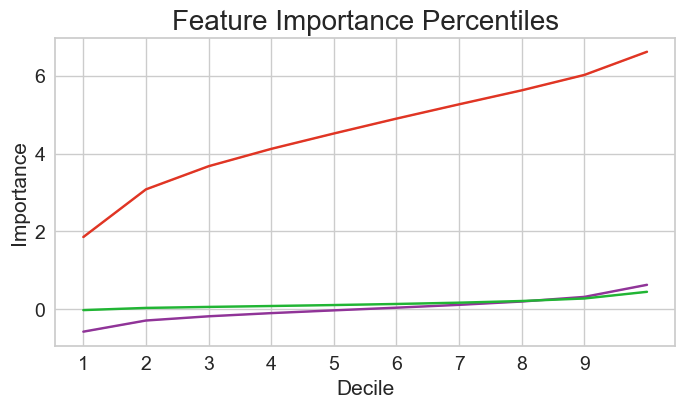

In [93]:
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set_style("whitegrid")

# create the line plot with percentile tick labels
sns.lineplot(data=feature_importance_df, x="Decile", y = "Importance", hue = "Feature Type", palette=["#903498", '#21b534', '#e03524'], ax=ax, legend = False, errorbar = 'se')
plt.xticks(np.arange(1, 10, 1), np.arange(1, 10, 1))

ax.tick_params(axis='x', labelsize= 14) 
ax.tick_params(axis='y', labelsize= 14) 
plt.title('Feature Importance Percentiles', fontsize = 20)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.savefig("../../figures/feature_importance_percentiles.svg", format = "svg", dpi = 300, bbox_inches='tight')


In [ ]:
feature_importance_matrix[699500:699528].shape

(28, 936)

In [14]:
feature_importance_grads = pd.read_csv("results/grad_feature_importance.csv")
feature_importance_conn = pd.read_csv("results/conn_feature_importance.csv")
feature_importance_disp = pd.read_csv("results/disp_feature_importance.csv")
feature_importance_disp_bthlhm = feature_importance_disp[699500:699528]
feature_importance_disp_bthlhm["Feature Type"] = "Centroid Disp"
feature_importance_disp = feature_importance_disp.drop(feature_importance_disp.index[699500:699528])
feature_importance_disp["Feature Type"] = "Cortex Disp"


#subset 100 most important features for each feature type
# feature_importance_grads = feature_importance_grads.sort_values(by=['Importance'], ascending=False).head(100)
# feature_importance_conn = feature_importance_conn.sort_values(by=['Importance'], ascending=False).head(100)
# feature_importance_disp = feature_importance_disp.sort_values(by=['Importance'], ascending=False).head(100)
# feature_importance_disp_bthlhm = feature_importance_disp_bthlhm.sort_values(by=['Importance'], ascending=False).head(100)


In [18]:
percentile = feature_importance_conn['Importance'].quantile(0.90)
feature_importance_conn = feature_importance_conn[feature_importance_conn['Importance'] >= percentile]

In [19]:
percentile = feature_importance_disp['Importance'].quantile(0.90)
feature_importance_disp = feature_importance_disp[feature_importance_disp['Importance'] >= percentile]

In [20]:
percentile = feature_importance_grads['Importance'].quantile(0.90)
feature_importance_grads = feature_importance_grads[feature_importance_grads['Importance'] >= percentile]

In [21]:
feature_importance_df = pd.concat([feature_importance_grads, feature_importance_conn, feature_importance_disp, feature_importance_disp_bthlhm])

In [22]:
# count the number of observations with importance > 0.2
feature_importance_df[feature_importance_df['Importance'] > 0.2].groupby(['Feature Type']).count()

Unnamed: 0  Importance  Percentile
Feature Type                                     
Centroid Disp          28          28          28
Connectivity        49950       49950       49950
Cortex Disp        100000      100000      100000
Gradients           20000       20000       20000

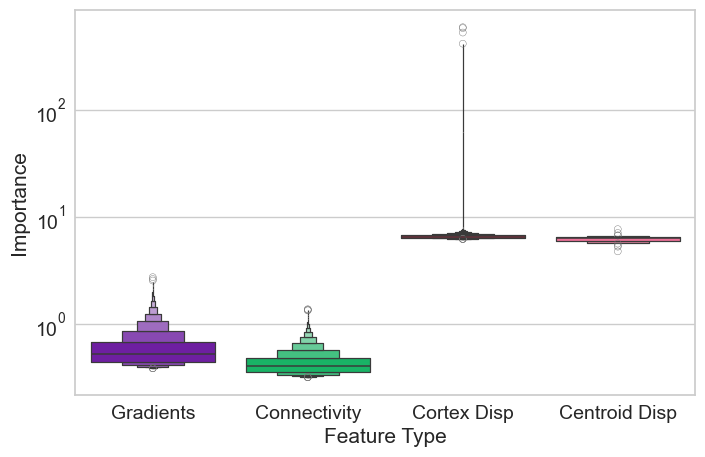

In [23]:
sns.set_style("whitegrid")
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxenplot(data=feature_importance_df, x="Feature Type", y="Importance", hue="Feature Type", palette = ["#7209b7", "#00cc66", "#f2002b", "#ff5d8f"], log_scale = (False, True), k_depth = "trustworthy")

ax.tick_params(axis='x', labelsize= 14)
ax.tick_params(axis='y', labelsize= 14)
#plt.title(label = "99% Threshold for Each Feature Type", fontsize = 20)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.8,1))
plt.savefig("../../figures/feature_importance_top1.svg", format = "svg", dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [115]:
lgd

In [ ]:
plt.savefig("../../figures/feature_importance.png", format = "png", dpi = 300, bbox_extra_artists=(lgd,))

<Figure size 800x550 with 0 Axes>

In [ ]:
plt.savefig("../../figures/feature_importance_top1.svg", format = "svg", dpi = 300, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [26]:
feature_importance_grads = pd.read_csv("results/grad_feature_importance.csv")
feature_labels = np.load("feature_labels.npy").tolist()
grad_labels = np.array([label.split("_")[-1] for label in feature_labels if "grad" in label]).astype(int)


FileNotFoundError: [Errno 2] No such file or directory: 'feature_labels.npy'

In [25]:
grad_labels = (grad_labels/1000).astype(int) + 1

In [ ]:
len(grad_labels)

200000

In [ ]:
len(feature_importance_grads)

200000

In [24]:
max_gradient_importance = feature_importance_grads["Importance"].values

In [25]:
grad_importance = pd.DataFrame({"Gradient": grad_labels, "Importance": max_gradient_importance})

NameError: name 'grad_labels' is not defined

In [28]:
grad_importance.sort_values(by = "Importance", ascending = False)

Gradient  Importance
70739         71    0.762777
70768         71    0.723147
166088       167    0.704376
63901         64    0.650764
13232         14    0.643596
...          ...         ...
9829          10    0.007786
153820       154    0.006645
80665         81    0.006338
23611         24    0.005803
28020         29    0.000000

[200000 rows x 2 columns]

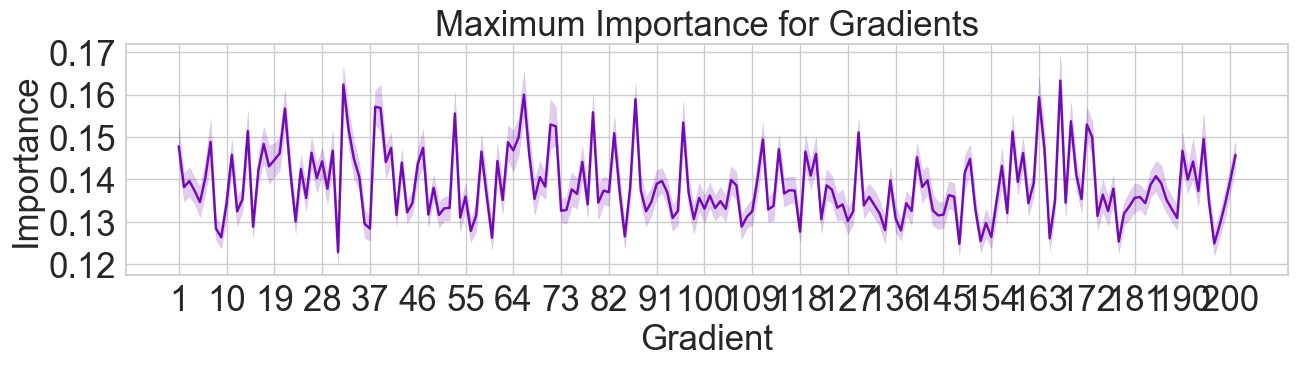

In [29]:
sns.set_style("whitegrid")
fig_dims = (15, 3)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=grad_importance, x="Gradient", y="Importance", color = "#7209b7")
plt.title(label = "Maximum Importance for Gradients", fontsize = 25)
ax.set_xticks(np.arange(1, 201, 9))
ax.set_xticklabels(np.append(np.arange(1, 201, 9)[:-1], 200))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=25)

ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
handles, labels = ax.get_legend_handles_labels()
plt.savefig("../../figures/gradient_importance.svg", format = "svg", dpi = 300, bbox_inches='tight')


In [122]:
perf1Grad_cv = pd.read_csv("results/separate_fits/best_936_1grad_cv.csv")
perfGrad_cv = pd.read_csv("results/separate_fits/best_936_grad_cv.csv")
perfBestConn_cv = pd.read_csv("results/separate_fits/best_936_conn_cv.csv")
perfBestDisp_cv = pd.read_csv("results/separate_fits/best_936_disp_cv.csv")
perfBthDisp_cv = pd.read_csv("results/separate_fits/bth_disp_cv.csv")

perf1Grad_test = pd.read_csv("results/separate_fits/best_936_1grad_test.csv")
perfGrad_test = pd.read_csv("results/separate_fits/best_936_grad_test.csv")
perfBestConn_test = pd.read_csv("results/separate_fits/best_936_conn_test.csv")
perfBestDisp_test = pd.read_csv("results/separate_fits/best_936_disp_test.csv")
perfBthDisp_test = pd.read_csv("results/separate_fits/bth_disp_test.csv")

In [28]:
#dummy_acc = perf1Grad.loc[perf1Grad['Model'] == 'Dummy Classifier']['Accuracy'].values[0]
#perf1Grad = perf1Grad[perf1Grad['Accuracy'] > dummy_acc]
#dummy_acc = perfBest1000.loc[perfBest1000['Model'] == 'Dummy Classifier']['Accuracy'].values[0]
#perfBest1000 = perfBest1000[perfBest1000['Accuracy'] > dummy_acc]

In [135]:
perf1Grad_cv["Features"] = "1st Gradient"
perfGrad_cv["Features"] = "Gradients"
perfBestConn_cv["Features"] = "Connectivity"
perfBestDisp_cv["Features"] = "Cortex Dispersion"
perfBthDisp_cv["Features"] = "Centroid Dispersion"


perf1Grad_test["Features"] = "1st Gradient"
perfGrad_test["Features"] = "Gradients"
perfBestConn_test["Features"] = "Connectivity"
perfBestDisp_test["Features"] = "Cortex Dispersion"
perfBthDisp_test["Features"] = "Centroid Dispersion"

perf_best936_cv = pd.concat([perfBestConn_cv, perf1Grad_cv, perfGrad_cv, perfBestDisp_cv,perfBthDisp_cv])
perf_best936_test = pd.concat([perfBestConn_test, perf1Grad_test, perfGrad_test, perfBestDisp_test, perfBthDisp_test])
# remove rows where accc is lower than dummy classifier
#perf_best936_cv = perf_best936_cv.groupby('Features').apply(lambda x: x.loc[x['Accuracy'] > 0.7344])
perf_best936_cv = perf_best936_cv[perf_best936_cv["Model"] != "Dummy Classifier"]

In [136]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu


statistic, p_value = kruskal(perf1Grad_cv["Accuracy"], perfGrad_cv["Accuracy"], perfBestConn_cv["Accuracy"], perfBestDisp_cv["Accuracy"], perfBthDisp_cv["Accuracy"])
print(statistic, p_value)


10.378468905503711 0.03451286766997127


In [130]:
statistic, p_value = kruskal(perf1Grad_cv["F1"], perfGrad_cv["F1"], perfBestConn_cv["F1"], perfBestDisp_cv["F1"], perfBthDisp_cv["F1"])
print(statistic, p_value)

18.733369015521756 0.0008866260481710137


In [131]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

statistic, p_value = mannwhitneyu(perfBestConn_cv["Accuracy"], perf1Grad_cv["Accuracy"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBestConn_cv["Accuracy"], perfGrad_cv["Accuracy"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBestConn_cv["Accuracy"], perfBestDisp_cv["Accuracy"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBestConn_cv["Accuracy"], perfBthDisp_cv["Accuracy"])
print(statistic, p_value)


147.5 0.024338425000830347
127.0 0.1902406952327642
139.5 0.0595497306403616
120.5 0.3118900054172862


<AxesSubplot: xlabel='Features', ylabel='Accuracy'>

<AxesSubplot: xlabel='Features', ylabel='Accuracy'>

[(0.49, 0.82)]

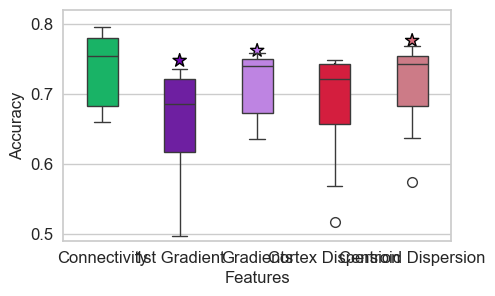

In [264]:
sns.set_style("whitegrid")
kwargs  =   {'edgecolor':"b", # for edge color
             'linewidth':1, # line width of spot
            }
fig_dims = (5, 3)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=perf_best936_test, x="Features", y="Accuracy", hue = "Features", palette = ["#00cc66", "#7209b7","#c174f2","#f2002b", "#d96e7d"], legend = False, ax = ax, s = 100,edgecolor = "black", linewidth = 1, marker = "*")
sns.boxplot(data=perf_best936_cv, x="Features", y="Accuracy", hue = "Features", dodge = False, palette = ["#00cc66", "#7209b7","#c174f2","#f2002b", "#d96e7d"], width=0.4)
ax.tick_params(axis='x', labelsize= 12)  
ax.tick_params(axis='y', labelsize= 12) 
ax.set(ylim=(0.49, 0.82))

ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.2,1), fontsize = 15)
#ax.get_legend().remove()
plt.savefig("../../figures/comparsion_perf_features_acc.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [147]:
statistic, p_value = mannwhitneyu(perfBestConn_cv["F1"], perf1Grad_cv["F1"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBestConn_cv["F1"], perfGrad_cv["F1"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBestConn_cv["F1"], perfBestDisp_cv["F1"])
print(statistic, p_value)
statistic, p_value = mannwhitneyu(perfBestConn_cv["F1"], perfBthDisp_cv["F1"])
print(statistic, p_value)


164.0 0.0026019882079162514
140.5 0.053598575808847866
168.5 0.0012963895629072534
152.5 0.01307008030633866


<AxesSubplot: xlabel='Features', ylabel='F1'>

<AxesSubplot: xlabel='Features', ylabel='F1'>

[(-0.05, 0.6)]

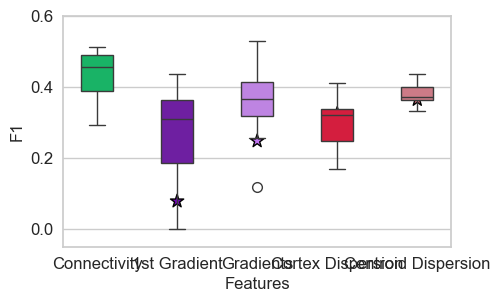

In [265]:
sns.set_style("whitegrid")
fig_dims = (5, 3)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data=perf_best936_cv, x="Features", y="F1", hue = "Features", dodge = False, palette = ["#00cc66", "#7209b7","#c174f2","#f2002b", "#d96e7d"], width=0.4)
sns.scatterplot(data=perf_best936_test, x="Features", y="F1", hue = "Features", palette = ["#00cc66", "#7209b7","#c174f2","#f2002b", "#d96e7d"], legend = False, ax = ax, s = 100,edgecolor = "black", linewidth = 1, marker = "*")
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
ax.set(ylim=(-0.05, 0.6))
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.2,1), fontsize = 15)
#ax.get_legend().remove()
plt.savefig("../../figures/comparsion_perf_features_f1.svg", format = "svg", dpi = 300, bbox_inches='tight')

#### Mann-Whitney U Test for Grad1 vs 1000 Best Features: AUC

In [ ]:
perf_grad_vs_1000best = perf_grad_vs_1000best[perf_grad_vs_1000best["F1"] > 0]

In [ ]:
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

f1_1grad = perf_grad_vs_1000best[perf_grad_vs_1000best["Features"] == "Principal Gradient"]["F1"]
f1_1000best = perf_grad_vs_1000best[perf_grad_vs_1000best["Features"] == "Best 1000 Features"]["F1"]
f1_1000bestConn = perf_grad_vs_1000best[perf_grad_vs_1000best["Features"] == "Best 1000 FC Features"]["F1"]
statistic, p_value = kruskal(f1_1grad, f1_1000best, f1_1000bestConn)
print(statistic, p_value)

14.747942410863756 0.0006273718032547797


In [ ]:
statistic, p_value = mannwhitneyu(f1_1grad, f1_1000best)
print(statistic, p_value)
statistic, p_value = mannwhitneyu(f1_1grad, f1_1000bestConn)
print(statistic, p_value)
statistic, p_value = mannwhitneyu(f1_1000best, f1_1000bestConn)
print(statistic, p_value)

22.0 0.0014753589570141526
18.5 0.0007806989290875257
95.0 0.6080768794659228


## Model Performance

In [149]:
cv_results[]

Model  Accuracy     AUC  Recall   Prec.      F1  \
0                 Ridge Classifier    0.7787  0.0000  0.4663  0.6241  0.5256   
1     Linear Discriminant Analysis    0.7787  0.7703  0.5007  0.6170  0.5431   
2              Logistic Regression    0.7741  0.7681  0.5065  0.6045  0.5424   
3     Gradient Boosting Classifier    0.7725  0.7943  0.3690  0.6212  0.4563   
4         Random Forest Classifier    0.7648  0.7659  0.2245  0.6668  0.3242   
...                            ...       ...     ...     ...     ...     ...   
1395              Ridge Classifier    0.6655  0.0000  0.4183  0.3747  0.3936   
1396           SVM - Linear Kernel    0.6566  0.0000  0.2922  0.3324  0.3034   
1397  Linear Discriminant Analysis    0.6411  0.6377  0.4879  0.3692  0.4171   
1398           Logistic Regression    0.6352  0.6010  0.3850  0.3388  0.3576   
1399                   Naive Bayes    0.5952  0.5874  0.4696  0.3152  0.3755   

       Kappa     MCC  TT (Sec)  N features       Feature Type  
0     0.3865  0.3982     0.146         100       Connectivity  
1     0.4007  0.4103     0.406         100       Connectivity  
2     0.3954  0.4037     1.118         100       Connectivity  
3     0.3270  0.3474     0.465         100       Connectivity  
4     0.2286  0.2803     0.209         100       Connectivity  
...      ...     ...       ...         ...                ...  
1395  0.1639  0.1655     6.401        9700  Cortex Dispersion  
1396  0.0809  0.0835     6.467        9700  Cortex Dispersion  
1397  0.1667  0.1717     6.947        9700  Cortex Dispersion  
1398  0.1063  0.1075     7.565        9700  Cortex Dispersion  
1399  0.0915  0.0987     6.357        9700  Cortex Dispersion  

[4200 rows x 11 columns]

In [183]:
cv_results_conn = pd.read_csv(f"results/model_results_cv_conn.csv")
cv_results_grad = pd.read_csv(f"results/model_results_cv_grad.csv")
cv_results_cortex_disp = pd.read_csv(f"results/model_results_cv_cortex_disp.csv")
test_results_conn = pd.read_csv(f"results/best_models_test_conn.csv")
test_results_grad = pd.read_csv(f"results/best_models_test_grad.csv")
test_results_cortex_disp = pd.read_csv(f"results/best_models_test_cortex_disp.csv")

cv_results_conn["Feature Type"] = "Connectivity"
cv_results_grad["Feature Type"] = "Gradients"
cv_results_cortex_disp["Feature Type"] = "Cortex Dispersion"
test_results_conn["Feature Type"] = "Connectivity"
test_results_grad["Feature Type"] = "Gradients"
test_results_cortex_disp["Feature Type"] = "Cortex Dispersion"

cv_results = pd.concat([cv_results_conn, cv_results_grad, cv_results_cortex_disp])
test_results = pd.concat([test_results_conn, test_results_grad, test_results_cortex_disp])

dummy_results = cv_results[cv_results["Model"] == "Dummy Classifier"]
dummy_acc = cv_results.loc[cv_results['Model'] == 'Dummy Classifier'].set_index('N features')['Accuracy'].values[0]
dummy_f1 = cv_results.loc[cv_results['Model'] == 'Dummy Classifier'].set_index('N features')['F1'].values[0]
dummy_filtered_cv_results = cv_results[cv_results["Accuracy"] > dummy_acc]
dummy_filtered_cv_results = dummy_filtered_cv_results.reset_index(drop=True)
dummy_filtered_cv_results["Performance"] = "CV"
test_results["Performance"] = "Test"

results = pd.concat([dummy_filtered_cv_results, test_results])

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

[(0.7, 0.85)]

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Accuracy')

[Text(-2000.0, 0, '−2000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000')]

[Text(0, 0.7000000000000001, '0.70'),
 Text(0, 0.7200000000000001, '0.72'),
 Text(0, 0.74, '0.74'),
 Text(0, 0.76, '0.76'),
 Text(0, 0.78, '0.78'),
 Text(0, 0.8, '0.80'),
 Text(0, 0.8200000000000001, '0.82'),
 Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86')]

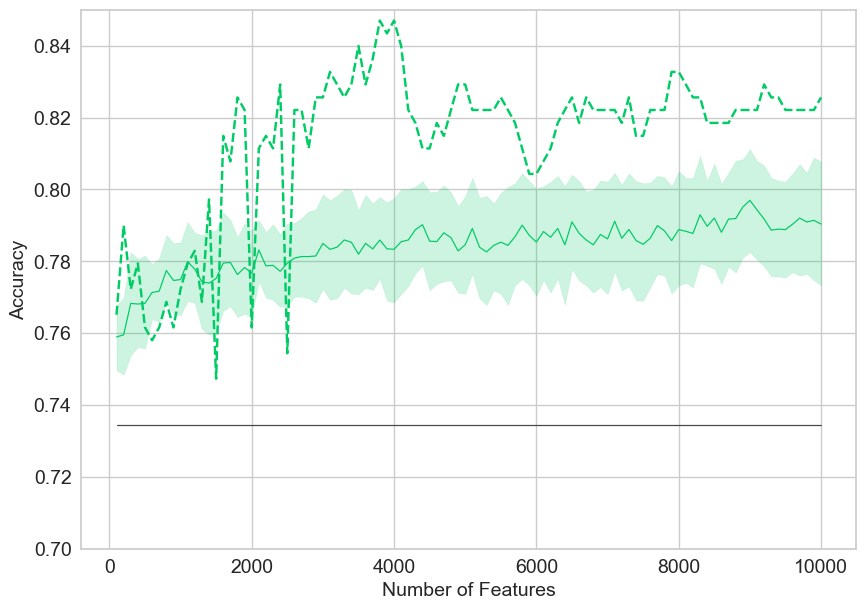

In [206]:
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=results[(results["Performance"] == "CV") & (results["Feature Type"] == "Connectivity")], estimator = "mean",
    x="N features", y="Accuracy", color="#00cc66", size = 0.8, legend = False #"#7209b7","#f2002b"
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", size =1, legend = False
)
sns.lineplot(
    data=results[(results["Performance"] == "Test") & (results["Feature Type"] == "Connectivity")], estimator = None,
    x="N features", y="Accuracy", color="#00cc66", linestyle = "--", legend = False
)
n_features = dummy_filtered_cv_results["N features"].values
# pval_acc = dummy_filtered_cv_results["Pval Acc"].values

ax.set(ylim=(0.70, 0.85))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# for i in range(1, len(n_features), 10):
#     if pval_acc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.9), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. acc., best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

# plt.axvline(x=926, color='gray', linestyle='-.')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("../../figures/acc_conn.svg", format = "svg", dpi = 300, bbox_inches='tight')

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

[(0.7, 0.85)]

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Accuracy')

[Text(-2000.0, 0, '−2000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000')]

[Text(0, 0.7000000000000001, '0.70'),
 Text(0, 0.7200000000000001, '0.72'),
 Text(0, 0.74, '0.74'),
 Text(0, 0.76, '0.76'),
 Text(0, 0.78, '0.78'),
 Text(0, 0.8, '0.80'),
 Text(0, 0.8200000000000001, '0.82'),
 Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86')]

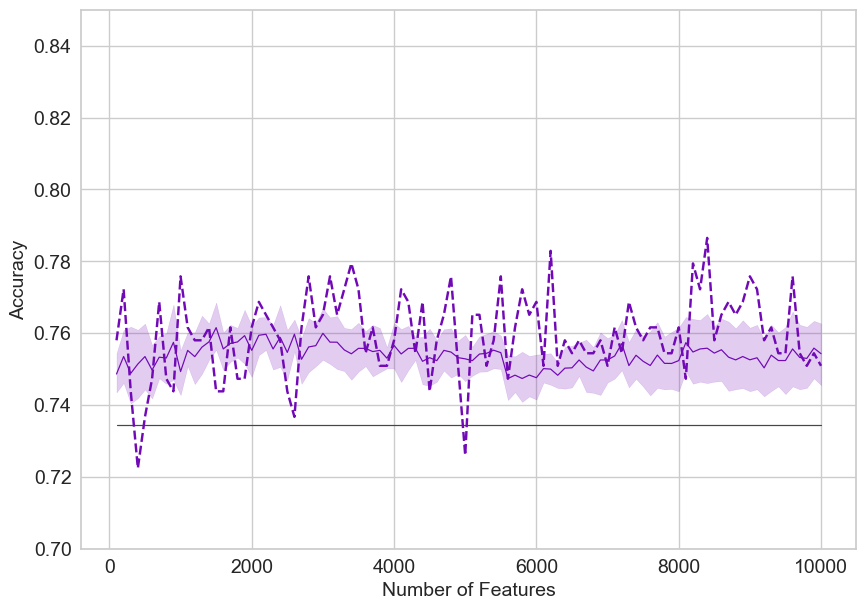

In [207]:
sns.set_style("whitegrid")
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=results[(results["Performance"] == "CV") & (results["Feature Type"] == "Gradients")], estimator = "mean",
    x="N features", y="Accuracy", color="#7209b7", size = 0.8, legend = False #"#7209b7","#f2002b"
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", size =1, legend = False
)
sns.lineplot(
    data=results[(results["Performance"] == "Test") & (results["Feature Type"] == "Gradients")], estimator = None,
    x="N features", y="Accuracy", color="#7209b7", linestyle = "--", legend = False
)
n_features = dummy_filtered_cv_results["N features"].values
# pval_acc = dummy_filtered_cv_results["Pval Acc"].values

ax.set(ylim=(0.70, 0.85))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# for i in range(1, len(n_features), 10):
#     if pval_acc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.9), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. acc., best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

# plt.axvline(x=926, color='gray', linestyle='-.')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("../../figures/acc_grad.svg", format = "svg", dpi = 300, bbox_inches='tight')

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

[(0.7, 0.85)]

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Accuracy')

[Text(-2000.0, 0, '−2000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000')]

[Text(0, 0.7000000000000001, '0.70'),
 Text(0, 0.7200000000000001, '0.72'),
 Text(0, 0.74, '0.74'),
 Text(0, 0.76, '0.76'),
 Text(0, 0.78, '0.78'),
 Text(0, 0.8, '0.80'),
 Text(0, 0.8200000000000001, '0.82'),
 Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86')]

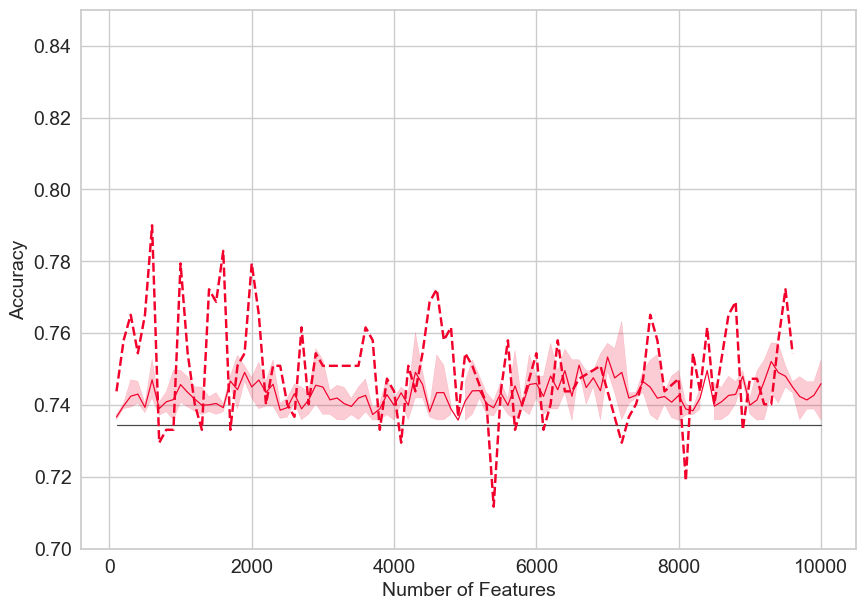

In [208]:
sns.set_style("whitegrid")
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=results[(results["Performance"] == "CV") & (results["Feature Type"] == "Cortex Dispersion")], estimator = "mean",
    x="N features", y="Accuracy", color="#f2002b", size = 0.8, legend = False #"#7209b7","#f2002b"
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", size =1, legend = False
)
sns.lineplot(
    data=results[(results["Performance"] == "Test") & (results["Feature Type"] == "Cortex Dispersion")], estimator = None,
    x="N features", y="Accuracy", color="#f2002b", linestyle = "--", legend = False
)
n_features = dummy_filtered_cv_results["N features"].values
# pval_acc = dummy_filtered_cv_results["Pval Acc"].values

ax.set(ylim=(0.70, 0.85))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# for i in range(1, len(n_features), 10):
#     if pval_acc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.9), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. acc., best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

# plt.axvline(x=926, color='gray', linestyle='-.')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("../../figures/acc_cortex_disp.svg", format = "svg", dpi = 300, bbox_inches='tight')

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

Text(0.5, 1.0, 'Connectivity')

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Accuracy')

(0.7, 0.85)

(100.0, 10000.0)

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

Text(0.5, 1.0, 'Gradients')

Text(0.5, 0, 'Number of Features')

(0.7, 0.85)

(100.0, 10000.0)

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

Text(0.5, 1.0, 'Cortex Dispersion')

Text(0.5, 0, 'Number of Features')

(0.7, 0.85)

(100.0, 10000.0)

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

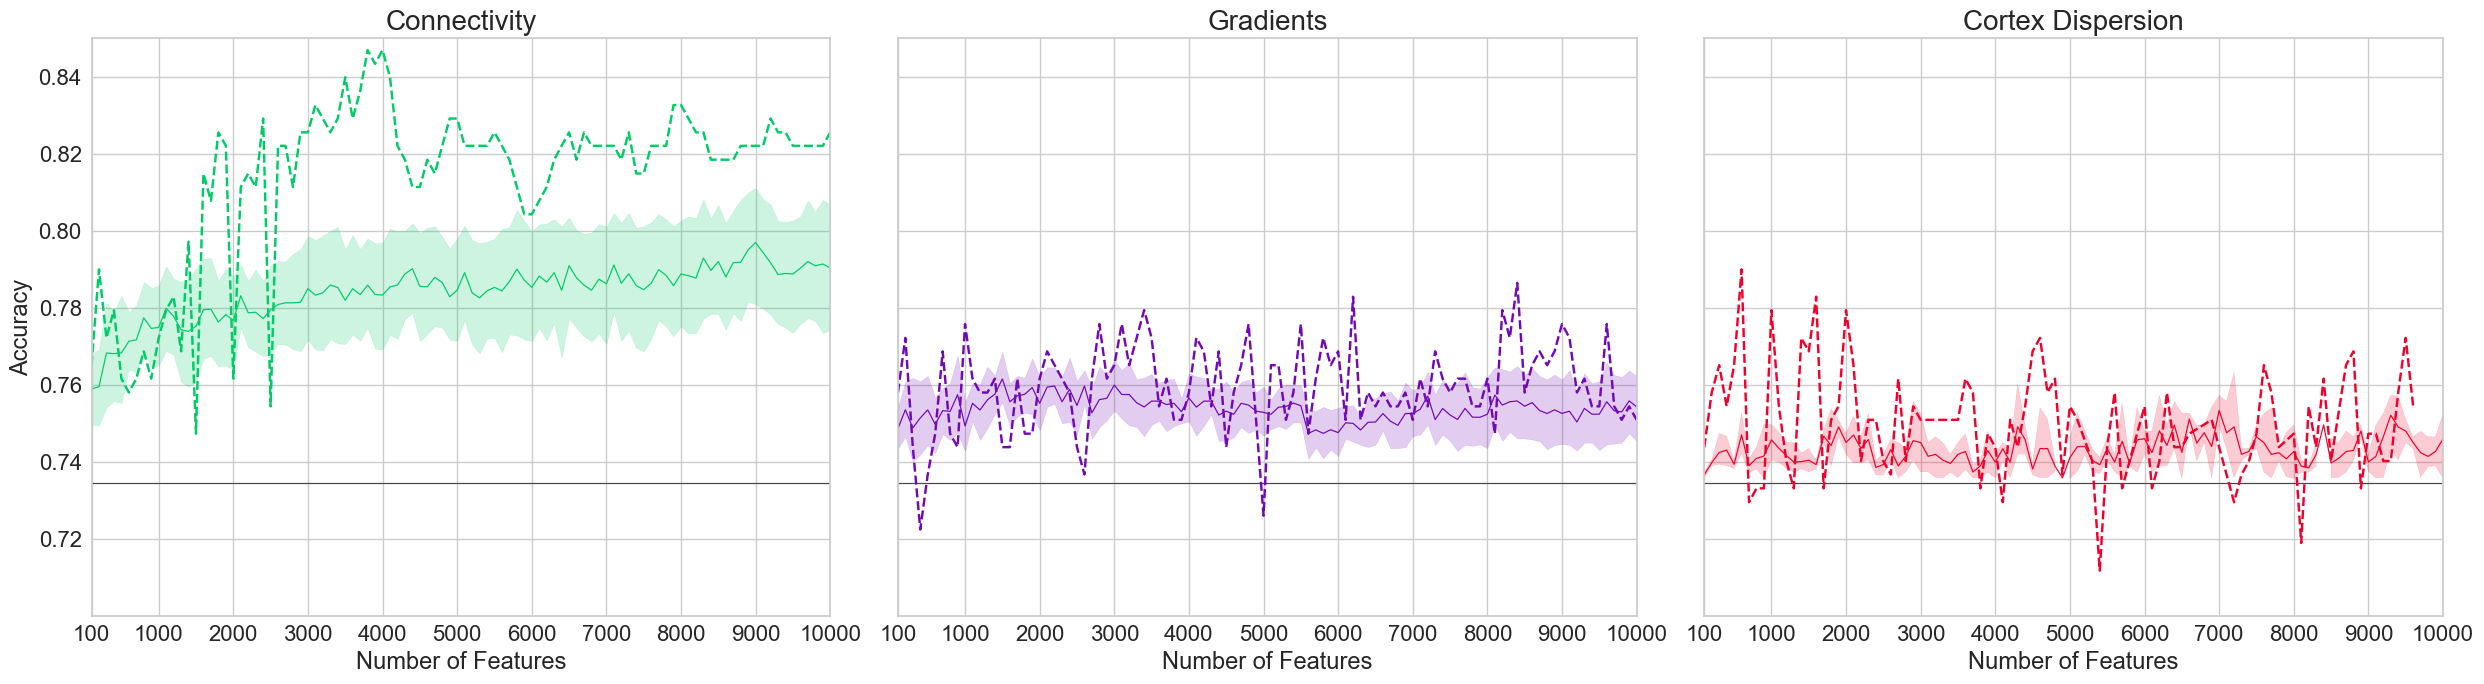

In [224]:
# Create a larger figure to hold three subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 7), sharey=True)

# Define titles for each subplot
titles = ['Connectivity', 'Gradients', 'Cortex Dispersion']
colors = ["#00cc66", "#7209b7", "#f2002b"]
x_ticks = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
# Plotting each feature type in a separate subplot
for i, feature_type in enumerate(titles):
    sns.lineplot(
        ax=axes[i],
        data=results[(results["Performance"] == "CV") & (results["Feature Type"] == feature_type)],
        estimator="mean",
        x="N features", y="Accuracy", color=colors[i], legend=False, palette=["#00cc66", "#7209b7","#f2002b"], size=1
    )
    sns.lineplot(
        ax=axes[i],
        data=dummy_results, estimator=None,
        x="N features", y="Accuracy", color="#464846", size=1, legend=False
    )
    sns.lineplot(
        ax=axes[i],
        data=results[(results["Performance"] == "Test") & (results["Feature Type"] == feature_type)],
        estimator=None,
        x="N features", y="Accuracy",color=colors[i], linestyle="--", legend=False
    )
    # Set the title, labels, ticks, and y-axis limits
    axes[i].set_title(titles[i], fontsize=20)
    axes[i].set_xlabel("Number of Features", fontsize=17)
    if i == 0:  # Only add y label to first plot to avoid repetition
        axes[i].set_ylabel("Accuracy", fontsize=17)
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_yticks(axes[i].get_yticks())
    axes[i].set_ylim(0.70, 0.85)

    # Set the x-axis limits to the min and max of the 'N features' for the specific feature type
    n_features_min = results[(results["Feature Type"] == feature_type)]['N features'].min()
    n_features_max = results[(results["Feature Type"] == feature_type)]['N features'].max()
    axes[i].set_xlim(n_features_min, n_features_max)


for ax in axes:
    ax.set_xticks(x_ticks)  # Set custom x-axis ticks
    ax.set_xticklabels(x_ticks, fontsize=16)  # Set custom x-axis tick labels with increased font size
    ax.tick_params(axis='y', labelsize=16) 
    
plt.tight_layout()

# Note: The savefig command is commented out because we do not actually have a destination to save the figure in this mock-up.
plt.savefig("../../figures/accuracy.svg", format="svg", dpi=300)


<AxesSubplot: xlabel='N features', ylabel='F1'>

<AxesSubplot: xlabel='N features', ylabel='F1'>

<AxesSubplot: xlabel='N features', ylabel='F1'>

Text(0.5, 1.0, 'Connectivity')

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'F1 score')

(-0.05, 0.7)

(100.0, 10000.0)

<AxesSubplot: xlabel='N features', ylabel='F1'>

<AxesSubplot: xlabel='N features', ylabel='F1'>

<AxesSubplot: xlabel='N features', ylabel='F1'>

Text(0.5, 1.0, 'Gradients')

Text(0.5, 0, 'Number of Features')

(-0.05, 0.7)

(100.0, 10000.0)

<AxesSubplot: xlabel='N features', ylabel='F1'>

<AxesSubplot: xlabel='N features', ylabel='F1'>

<AxesSubplot: xlabel='N features', ylabel='F1'>

Text(0.5, 1.0, 'Cortex Dispersion')

Text(0.5, 0, 'Number of Features')

(-0.05, 0.7)

(100.0, 10000.0)

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

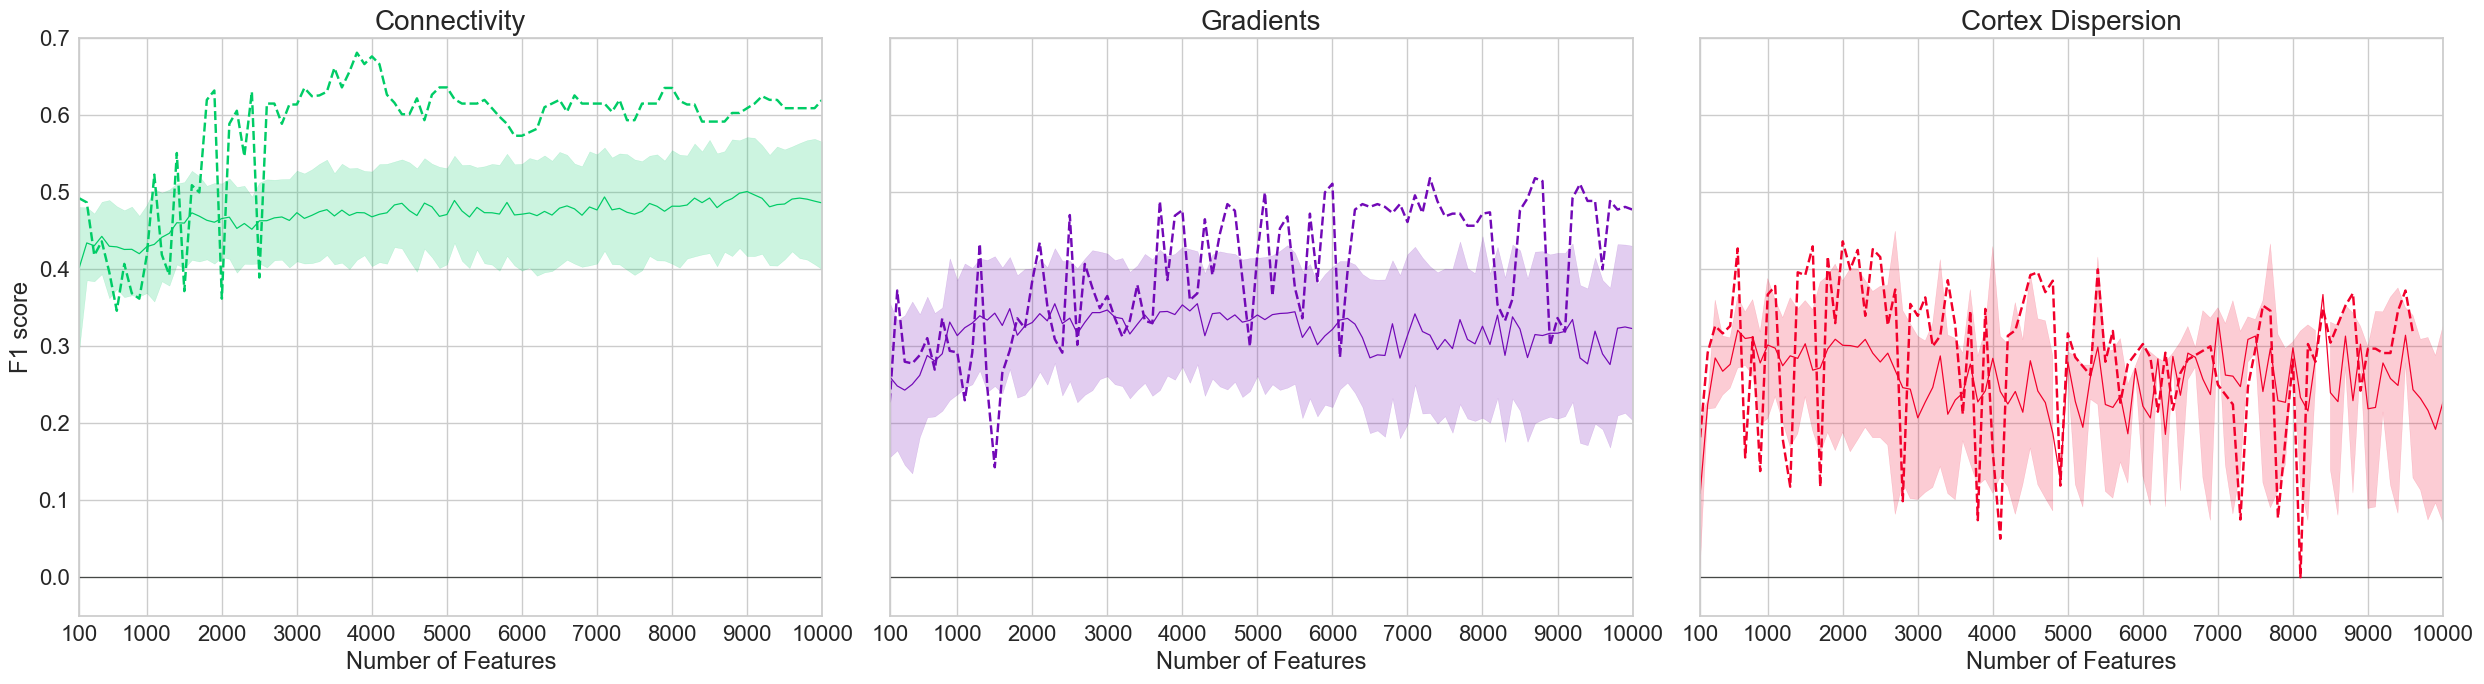

In [229]:
# Create a larger figure to hold three subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 7), sharey=True)

# Define titles for each subplot
titles = ['Connectivity', 'Gradients', 'Cortex Dispersion']
colors = ["#00cc66", "#7209b7", "#f2002b"]
x_ticks = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
# Plotting each feature type in a separate subplot
for i, feature_type in enumerate(titles):
    sns.lineplot(
        ax=axes[i],
        data=results[(results["Performance"] == "CV") & (results["Feature Type"] == feature_type)],
        estimator="mean",
        x="N features", y="F1", color=colors[i], legend=False, palette=["#00cc66", "#7209b7","#f2002b"], size=1
    )
    sns.lineplot(
        ax=axes[i],
        data=dummy_results, estimator=None,
        x="N features", y="F1", color="#464846", size=1, legend=False
    )
    sns.lineplot(
        ax=axes[i],
        data=results[(results["Performance"] == "Test") & (results["Feature Type"] == feature_type)],
        estimator=None,
        x="N features", y="F1",color=colors[i], linestyle="--", legend=False
    )
    # Set the title, labels, ticks, and y-axis limits
    axes[i].set_title(titles[i], fontsize=20)
    axes[i].set_xlabel("Number of Features", fontsize=17)
    if i == 0:  # Only add y label to first plot to avoid repetition
        axes[i].set_ylabel("F1 score", fontsize=17)
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_yticks(axes[i].get_yticks())
    axes[i].set_ylim(-0.05, 0.7)

    # Set the x-axis limits to the min and max of the 'N features' for the specific feature type
    n_features_min = results[(results["Feature Type"] == feature_type)]['N features'].min()
    n_features_max = results[(results["Feature Type"] == feature_type)]['N features'].max()
    axes[i].set_xlim(n_features_min, n_features_max)


for ax in axes:
    ax.set_xticks(x_ticks)  # Set custom x-axis ticks
    ax.set_xticklabels(x_ticks, fontsize=16)  # Set custom x-axis tick labels with increased font size
    ax.tick_params(axis='y', labelsize=16) 
    
plt.tight_layout()

# Note: The savefig command is commented out because we do not actually have a destination to save the figure in this mock-up.
plt.savefig("../../figures/f1.svg", format="svg", dpi=300, bbox_inches='tight')


In [36]:
# best_models_test = pd.read_csv(f"results/best_models_test.csv")
# cv_results = pd.read_csv(f"results/model_results_cv.csv")

# best_cv_results = cv_results.groupby('N features').apply(lambda x: x.loc[x['Accuracy'].idxmax()])
# best_cv_results=best_cv_results.reset_index(drop=True)

# dummy_acc = cv_results.loc[cv_results['Model'] == 'Dummy Classifier'].set_index('N features')['Accuracy']
# dummy_auc = cv_results.loc[cv_results['Model'] == 'Dummy Classifier'].set_index('N features')['AUC']
# dummy_filtered_results = cv_results.groupby('N features').apply(lambda x: x.loc[x['Accuracy'] > dummy_acc[x.name]])
# dummy_filtered_results = dummy_filtered_results.reset_index(drop=True)


In [37]:
from scipy.stats import percentileofscore

for n_features in best_models_test["N features"].unique():
    n_features = int(n_features)
    try:
        null_dist_acc = np.load(f"results/null_dist/null_dist_{n_features}.npy")[:, 0]
        null_dist_auc = np.load(f"results/null_dist/null_dist_{n_features}.npy")[:, 1]

        best_acc = best_models_test[best_models_test["N features"] == float(n_features)]["Accuracy"].values[0]
        best_auc = best_models_test[best_models_test["N features"] == float(n_features)]["AUC"].values[0]

        pval_acc = 1-percentileofscore(null_dist_acc, best_acc) / 100
        pval_auc = 1-percentileofscore(null_dist_auc, best_auc) / 100

        best_models_test.loc[best_models_test["N features"] == float(n_features), "Pval Acc"] =  pval_acc
        best_models_test.loc[best_models_test["N features"] == float(n_features), "Pval AUC"] =  pval_auc
    except:
        pass

In [38]:
best_model_test_pca = pd.read_csv(f"results/pca_features_best_model_test.csv")
best_model_test_confound = pd.read_csv(f"results/confounds_best_model_test.csv")
dummy_results = pd.read_csv(f"results/pca_dummy_test.csv")

n_models = 14
n_levels = len(best_models_test["N features"].unique())
best_model_test_confound = pd.concat([best_model_test_confound]*n_levels, ignore_index=True)
best_model_test_confound["N features"] = list(best_models_test["N features"].unique())

best_model_test_pca = pd.concat([best_model_test_pca]*n_levels, ignore_index=True)
best_model_test_pca["N features"] = list(best_models_test["N features"].unique())

dummy_results = pd.concat([dummy_results]*n_levels, ignore_index=True)
dummy_results["N features"] = list(best_models_test["N features"].unique())


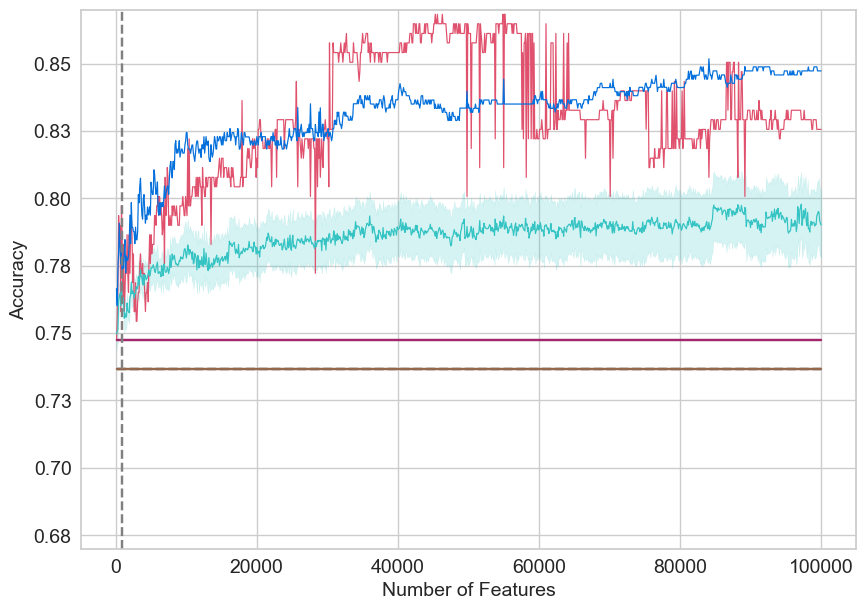

In [63]:
from matplotlib.ticker import FormatStrFormatter

sns.set_style("whitegrid")
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=best_models_test, estimator = None,
    x="N features", y="Accuracy", color="#e0516d", size = 0.7, legend = False
)
sns.lineplot(
    data=best_cv_results, estimator = None,
    x="N features", y="Accuracy", color="#0470dc", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_filtered_results, errorbar = 'se',
    x="N features", y="Accuracy", color="#35c4c3", size = 0.7, legend = False
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", linestyle = "--"
)
sns.lineplot(
    data=best_model_test_confound,x = "N features", y="Accuracy", color="#95684b"
)
sns.lineplot(
    data=best_model_test_pca,x = "N features", y="Accuracy", color="#a1286a"
)

n_features = best_models_test["N features"].values
pval_acc = best_models_test["Pval Acc"].values

ax.set(ylim=(0.67, 0.87))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# for i in range(1, len(n_features), 10):
#     if pval_acc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.9), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. acc., best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

plt.axvline(x=936, color='gray', linestyle='--')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("../../figures/Accuracy.svg", format = "svg", dpi = 300, bbox_inches='tight')

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

<AxesSubplot: xlabel='N features', ylabel='Accuracy'>

[(0.7, 0.85)]

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Accuracy')

[Text(-2000.0, 0, '−2000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000')]

[Text(0, 0.7000000000000001, '0.70'),
 Text(0, 0.7200000000000001, '0.72'),
 Text(0, 0.74, '0.74'),
 Text(0, 0.76, '0.76'),
 Text(0, 0.78, '0.78'),
 Text(0, 0.8, '0.80'),
 Text(0, 0.8200000000000001, '0.82'),
 Text(0, 0.8400000000000001, '0.84'),
 Text(0, 0.8600000000000001, '0.86')]

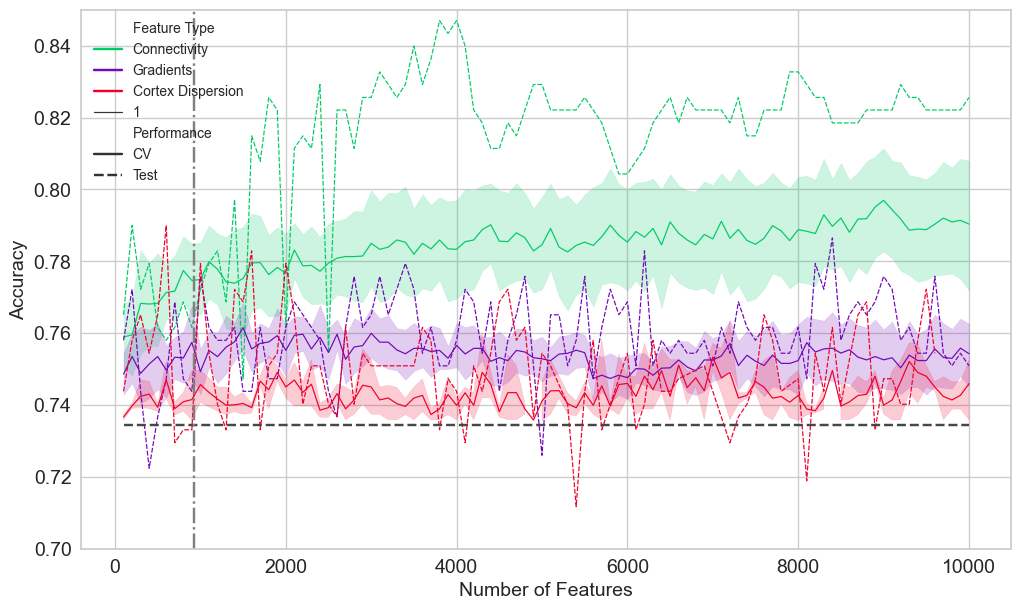

In [230]:

sns.set_style("whitegrid")
fig_dims = (12, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(
    data=results,
    x="N features", y="Accuracy", hue = "Feature Type", palette=["#00cc66", "#7209b7","#f2002b"], size = 1, legend = True, style = "Performance"
)
sns.lineplot(
    data=dummy_results, estimator = None,
    x="N features", y="Accuracy", color="#464846", linestyle = "--", legend = False
)

n_features = dummy_filtered_cv_results["N features"].values
# pval_acc = dummy_filtered_cv_results["Pval Acc"].values

ax.set(ylim=(0.70, 0.85))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# for i in range(1, len(n_features), 10):
#     if pval_acc[i] > 0.05:
#         ax.annotate("x", xy=(n_features[i], 0.9), fontsize=16, ha="center", color = "#980000", label = "Best model: significance")
# ax.annotate("Non-Sig. acc., best model", xy=(20000, 0.848), fontsize=14, ha="center", color = "#980000")

plt.axvline(x=926, color='gray', linestyle='-.')
ax.set_xlabel("Number of Features", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
plt.savefig("../../figures/legend.svg", format = "svg", dpi = 300, bbox_inches='tight')

In [252]:
model_colors = [
    "#ff002b", #red
    "#6a00ff", #purple
    "#09f04a", #green
    "#2d2dd6", #dark blue
    "#fcf300", #yellow
    "#0e581d", #dark green
    "#fe436a", #pink
    "#64171c", #brown
    "#ff9500", #orange
    "#bb9262", #beige
    "#0095ff", #light blue
]


<AxesSubplot: xlabel='N features', ylabel='Density'>

(100.0, 10000.0)

[Text(100, 0, '100'),
 Text(1000, 0, '1000'),
 Text(2000, 0, '2000'),
 Text(3000, 0, '3000'),
 Text(4000, 0, '4000'),
 Text(5000, 0, '5000'),
 Text(6000, 0, '6000'),
 Text(7000, 0, '7000'),
 Text(8000, 0, '8000'),
 Text(9000, 0, '9000'),
 Text(10000, 0, '10000')]

Text(0.5, 0, 'Number of Features')

Text(0, 0.5, 'Relative Density')

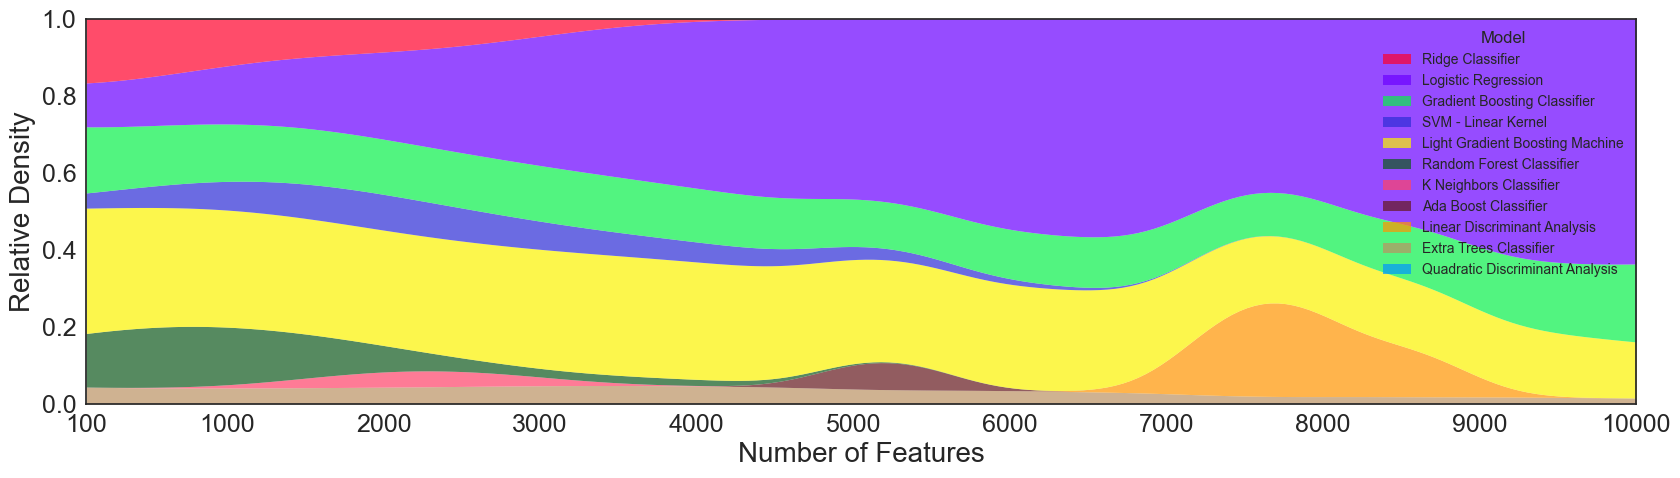

In [261]:
sns.set_style("white")
fig_dims = (20, 5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.kdeplot(
    data=results[results["Performance"] == "Test"], 
    x="N features", 
    hue="Model", 
    cumulative=False, 
    multiple="fill", 
    cut=0, 
    common_norm=True, 
    bw_adjust=1.2, 
    bw_method='silverman', 
    palette=model_colors, 
    alpha=0.7, 
    fill=True, 
    linewidth=0, 
    legend=True
)

ax.set_xlim([100, 10000])

# Set custom x-axis tick labels
custom_ticks = [100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
ax.set_xticks(custom_ticks)  # Setting custom x-axis ticks
ax.set_xticklabels(custom_ticks, fontsize=18)  # Setting custom x-axis tick labels
ax.tick_params(axis='y', labelsize=18) 

ax.set_xlabel("Number of Features", fontsize=20)
ax.set_ylabel("Relative Density", fontsize=20)

plt.savefig("../../figures/model_rank.svg", format = "svg", dpi = 300, bbox_inches='tight')

array(['Gradient Boosting Classifier', 'K Neighbors Classifier',
       'Random Forest Classifier', 'Light Gradient Boosting Machine',
       'Linear Discriminant Analysis', 'Logistic Regression'],
      dtype=object)

## Feature Interpretation: Neurosynth & Cortical Surface

In [44]:
feature_importance = np.load("feature_importance_matrix.npy")


In [72]:
adj_mat = conn_features_to_adj(936, feature_importance[:499500])

In [73]:
from nltools.data import Adjacency
adj_mat = Adjacency(adj_mat, matrix_type='similarity', labels = [x for x in range(0, 1000)])
graph = adj_mat.to_graph()
degree = graph.degree()


In [74]:
degree_centrality = np.array(list(dict(degree).values()), dtype = float)

In [75]:
degree_centrality = map_to_labels(degree_centrality, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

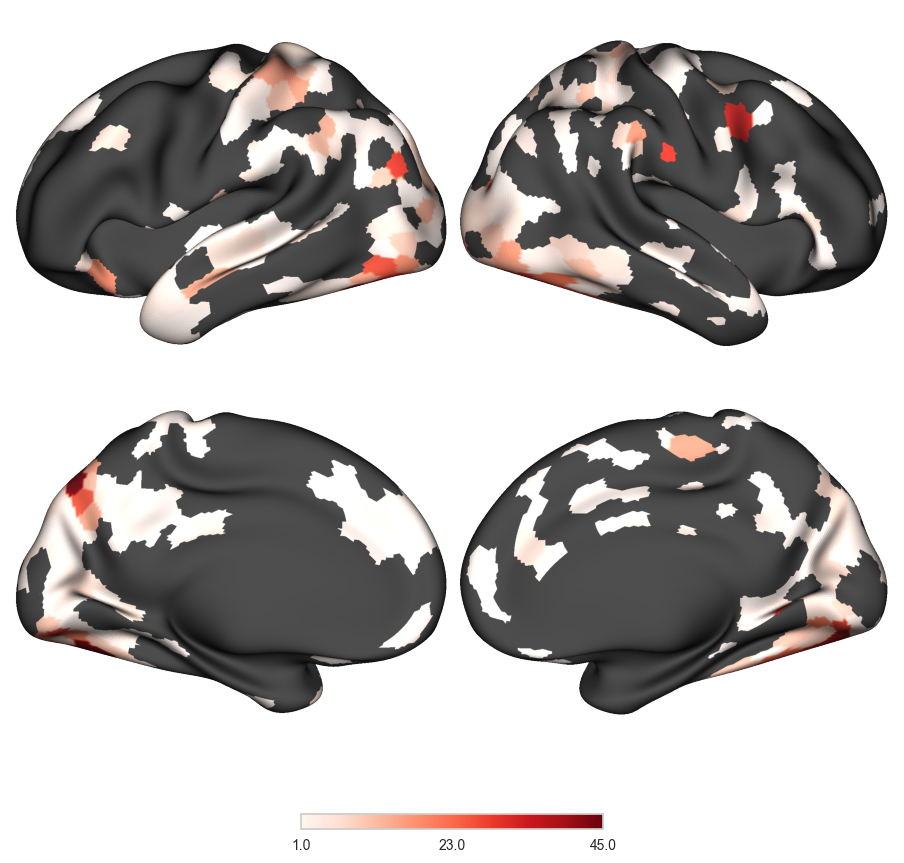

: 

In [77]:
lh, rh = surfaces['inflated']

degree_plot = Plot(lh, rh, size=(1200, 1000), brightness=8)

degree_plot.add_layer({'left': degree_centrality[:32492], 'right': degree_centrality[32492:]}, cbar=True, cmap="Reds")
# degree_plot.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
#             as_outline=True, cbar=False)
fig = degree_plot.build()
fig.savefig(f"../../figures/cortex_regions/degree_centrality.svg", format = "svg", dpi = 300, bbox_inches='tight')

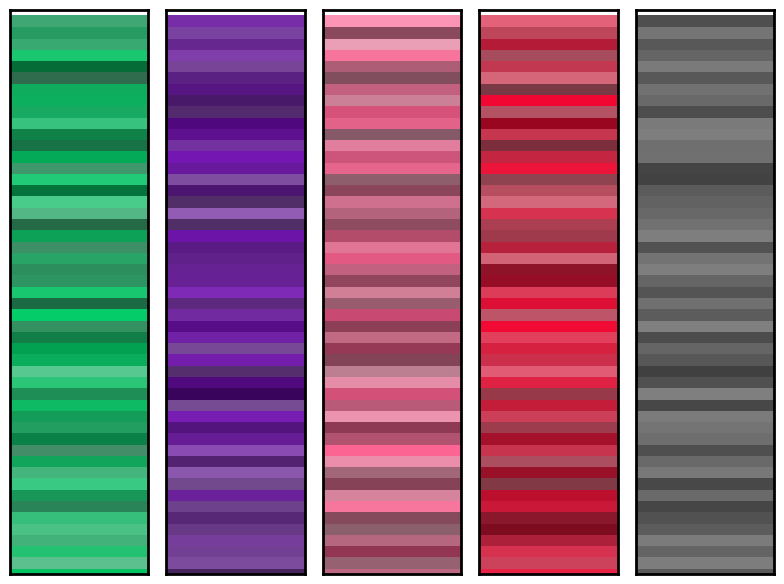

In [12]:
import matplotlib.colors as mcolors

n_lines = 50
n_columns = 5  # Updated to 5 columns
base_colors = ["#00cc66", "#7209b7", "#ff5d8f", "#f2002b", "#808080"]  # Added gray color

def random_adjustment_hsv(color, sat_range=(0.5, 1.0), value_range=(0.5, 1.0)):
    # Convert hex to RGB
    color_rgb = mcolors.hex2color(color)
    # Convert RGB to HSV
    color_hsv = mcolors.rgb_to_hsv(color_rgb)
    # Randomly adjust the saturation and value within given range for contrast and opacity
    new_saturation = color_hsv[1] * np.random.uniform(sat_range[0], sat_range[1])
    new_value = color_hsv[2] * np.random.uniform(value_range[0], value_range[1])
    # Ensure the saturation and value remain within [0, 1]
    new_saturation = min(max(new_saturation, 0), 1)
    new_value = min(max(new_value, 0), 1)
    # Set the new saturation and value
    color_hsv[1] = new_saturation
    color_hsv[2] = new_value
    # Convert back to RGB
    new_color_rgb = mcolors.hsv_to_rgb(color_hsv)
    # Return the new color in hex format
    return mcolors.to_hex(new_color_rgb)

# Generate y positions for horizontal lines in raster plot, adjusted to fill the space
y_positions = np.linspace(0, 1, n_lines, endpoint=False)

# Create a figure and axes
fig, axes = plt.subplots(1, n_columns, figsize=(8, 6), sharey=True)  # Adjusted figsize for 5 columns

# Plot horizontal raster plot with colored lines in each column
for i in range(n_columns):
    # Get the base color for the current column
    base_color = base_colors[i]
    
    # Plot each line with random opacity and contrast
    for y_pos in y_positions:
        # Adjust the color saturation and value
        color = random_adjustment_hsv(base_color)
        # Plot the horizontal line with the new color and random alpha for opacity
        # Increase linewidth as needed to fill gaps
        axes[i].hlines(y=y_pos, xmin=0, xmax=1, color=color, linewidth=(1.0 / n_lines) * fig.get_size_inches()[1] * 72)

    # Outline the column
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)

# Set properties of the axes
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])  # Adjusted to use relative positions
    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()

fig.savefig(f"../../figures/dataset_schematic.svg", format = "svg", dpi = 300, bbox_inches='tight')


In [19]:
from sympy import symbols, latex
import matplotlib.pyplot as plt

# Enable LaTeX in plots for matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define the symbols
I_conn, P_conn_inv, I_PCA_conn, I_cortex_disp, P_cortex_disp_inv, I_PCA_cortex_disp = symbols(
    'I_{conn} P_{conn}^{-1} I_{PCA_{conn}} I_{cortex_disp} P_{cortex_disp}^{-1} I_{PCA_{cortex_disp}}')

# Manually create the LaTeX strings using \mathrm
eq1_latex = r'I_{\mathrm{conn}} = P_{\mathrm{conn}}^{-1} I_{\mathrm{PCA}_{\mathrm{conn}}}'
eq2_latex = r'I_{\mathrm{cortex{\textunderscore}disp}} = P_{\mathrm{cortex{\textunderscore}disp}}^{-1} I_{\mathrm{PCA}_{\mathrm{cortex{\textunderscore}disp}}}'

# Function to plot and save LaTeX expression as SVG
def save_expr_as_svg(expr, filename):
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.text(0.5, 0.5, f"${expr}$", fontsize=30, ha='center', va='center')
    fig.savefig(filename, format='svg', bbox_inches='tight')
    plt.close(fig)

# Save each equation as an SVG file
svg_filenames = []
for i, expr_latex in enumerate([eq1_latex, eq2_latex], start=1):
    filename = f'../../figures/reverse_transform_{i}.svg' # Change path to your preferred location
    save_expr_as_svg(expr_latex, filename)
    svg_filenames.append(filename)

